In [188]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing the numerical data


In [52]:
# Download historical stock data
stock_symbol = '^BSESN'  # SENSEX symbol on Yahoo Finance
start_date = '2014-07-01'
end_date = '2024-07-08'
df = yf.download(stock_symbol, start=start_date, end=end_date)

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-01,25469.939453,25571.900391,25466.769531,25516.349609,25516.349609,10600
2014-07-02,25660.570312,25864.529297,25660.160156,25841.210938,25841.210938,12300
2014-07-03,25875.750000,25999.080078,25793.699219,25823.750000,25823.750000,3700
2014-07-04,25844.800781,25981.509766,25659.330078,25962.060547,25962.060547,9500
2014-07-07,26039.669922,26123.550781,25992.730469,26100.080078,26100.080078,8900


### Analysis on the Numerical Data

In [3]:
df.shape

(2456, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2456 entries, 2014-07-01 to 2024-07-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2456 non-null   float64
 1   High       2456 non-null   float64
 2   Low        2456 non-null   float64
 3   Close      2456 non-null   float64
 4   Adj Close  2456 non-null   float64
 5   Volume     2456 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.3 KB


In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<Axes: xlabel='Date'>

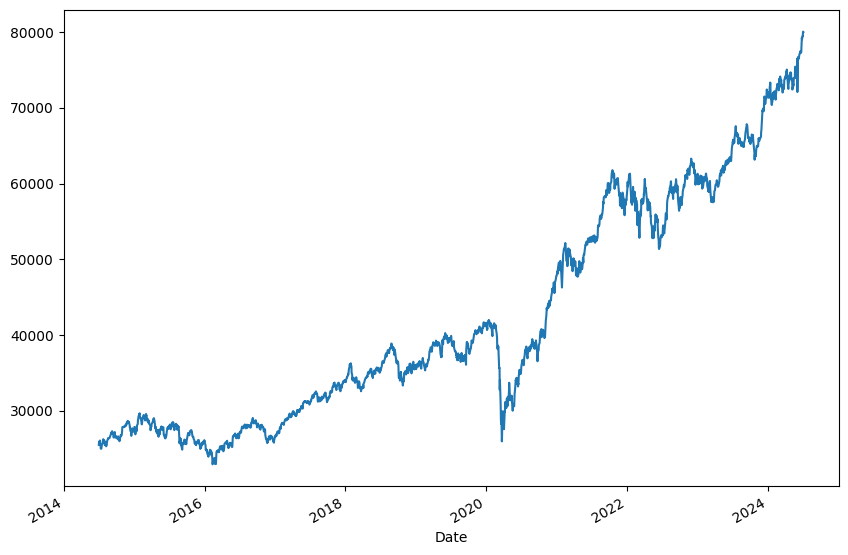

In [6]:
plt.figure(figsize=(10,7))
df['Close'].plot()

# It shows the stock price variations from last 10 years

In [7]:
df.sort_index(inplace=True)

# Split data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

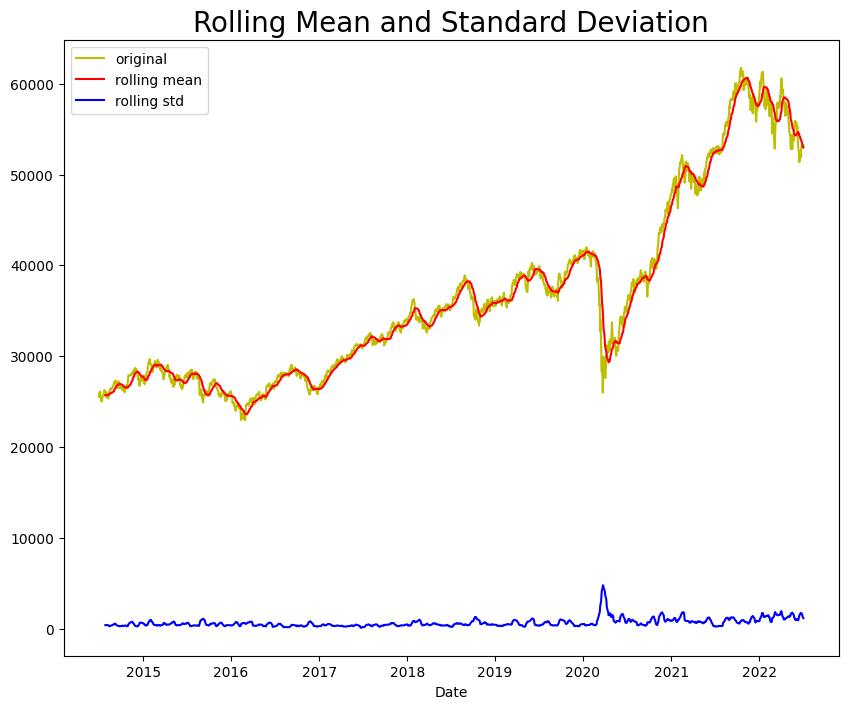

Results of dickey fuller test
ADF Test Statistic : -0.5365612519161961
p-value : 0.884682199274668
#Lags Used : 12
Number of Observations Used : 1951
Weak evidence against null hypothesis, time series is non-stationary 


In [8]:
#Stationarity test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize = (10,8))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
    plt.show(block = False)

    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

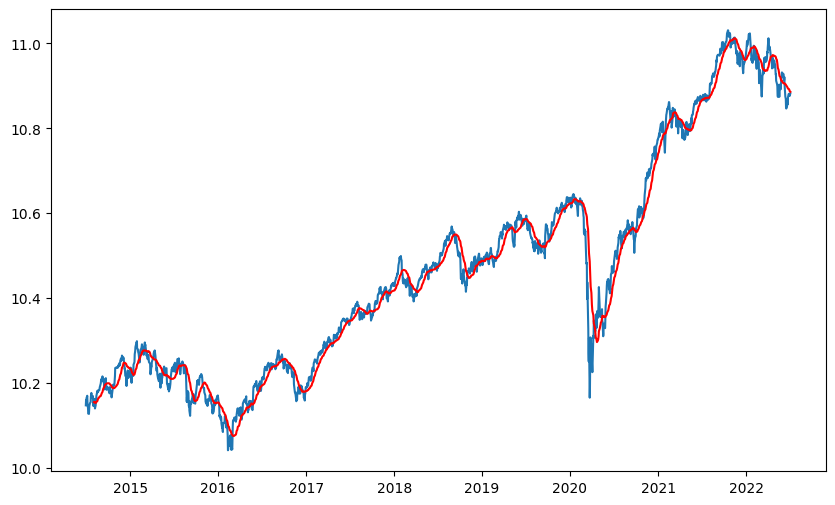

In [9]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (10,6))
plt.plot(train_log)
plt.plot(mav, color = 'red')


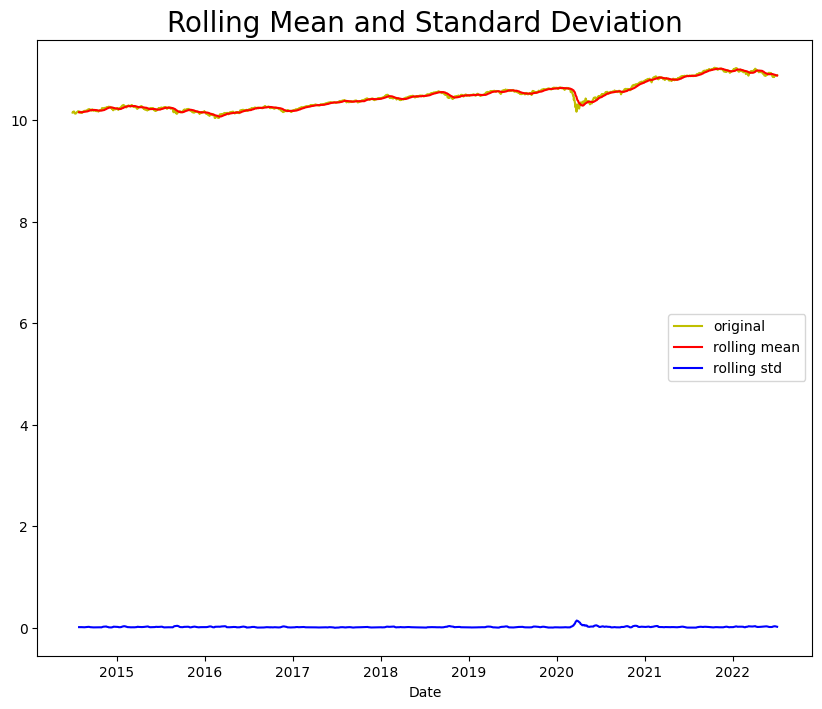

Results of dickey fuller test
ADF Test Statistic : -0.7700399262168207
p-value : 0.8277646152410141
#Lags Used : 12
Number of Observations Used : 1951
Weak evidence against null hypothesis, time series is non-stationary 


In [10]:

train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)



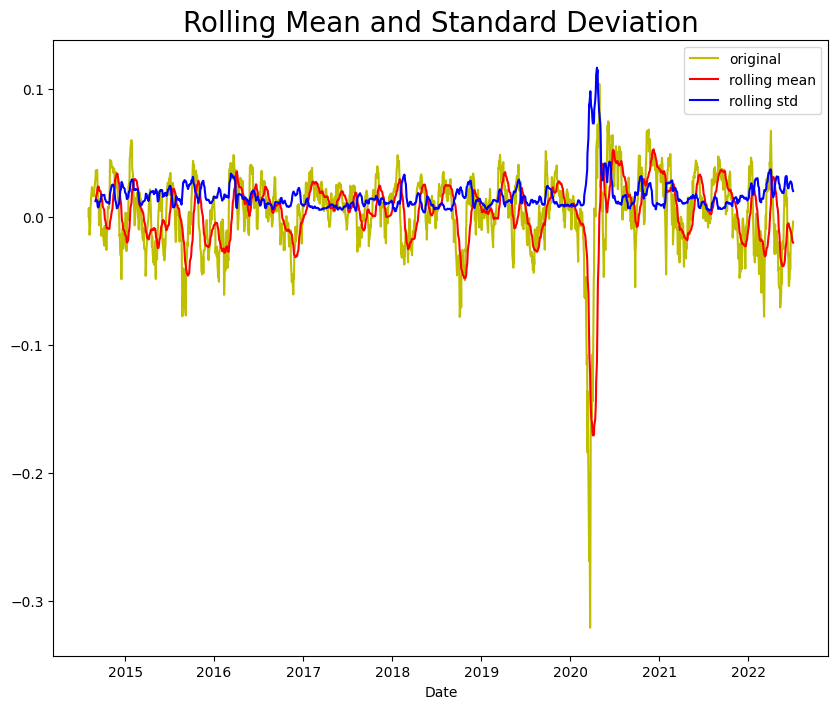

Results of dickey fuller test
ADF Test Statistic : -8.986770203932052
p-value : 7.066371971661948e-15
#Lags Used : 12
Number of Observations Used : 1928
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [11]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)


In [15]:
#Using auto arima to make predictions using log data
model = auto_arima(train['Close'], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Print the summary of the best model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=15.07 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=34029.680, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=30322.125, Time=7.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=32281.685, Time=15.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=34052.325, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=30801.832, Time=0.97 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=30192.836, Time=17.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=29940.741, Time=38.46 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=16.91 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=43.22 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=37.66 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=34034.849, Time=5.57 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=42.95 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=42.53 sec
 ARIMA(0,0,1)(2,1,1)[12] interce

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


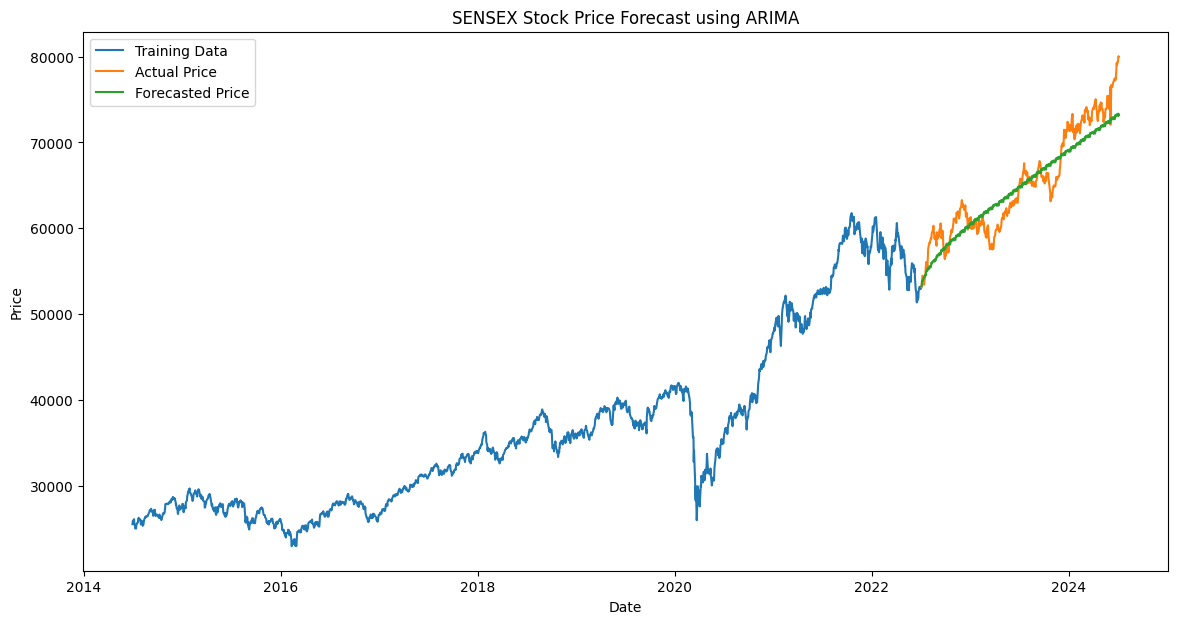

In [16]:
model.fit(train['Close'])

# Forecast future values (adjust 'n_periods' as needed)
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Plot the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual Price')
plt.plot(test.index, forecast, label='Forecasted Price')
plt.title('SENSEX Stock Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
# Assuming 'test' contains your test set with actual values and 'predictions' contains predicted values
rmse = np.sqrt(mean_squared_error(test['Close'], forecast))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 2317.925534327185


### Textual Analysis

### Importing the textual data

In [18]:
# Load news headlines data

news_data = pd.read_csv(r"/content/india-news-headlines-filtered.csv")
news_data

,publish_date,headline_category,headline_text
0,2014-07-01,life-style.food.recipes,Recipe: Delicious Tiramisu
1,2014-07-01,life-style.relationships.man-woman,God helps you when romance fails
2,2014-07-01,life-style.food.recipes,Get cooking with mangoes
3,2014-07-01,life-style.food.drinks-corner,Creative coolers for the summer
4,2014-07-01,life-style.relationships.man-woman,Make your selfies look better than you
...,...,...,...
1729308,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
1729309,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
1729310,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
1729311,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [19]:
news_data.dropna(inplace=True)

In [20]:
news_data = news_data.rename(columns={
    'publish_date': 'date',
    'headline_category': 'category',
    'headline_text': 'news'
})
news_data.head()

,date,category,news
0,2014-07-01,life-style.food.recipes,Recipe: Delicious Tiramisu
1,2014-07-01,life-style.relationships.man-woman,God helps you when romance fails
2,2014-07-01,life-style.food.recipes,Get cooking with mangoes
3,2014-07-01,life-style.food.drinks-corner,Creative coolers for the summer
4,2014-07-01,life-style.relationships.man-woman,Make your selfies look better than you


In [21]:
#Grouping the headlines for each day
news_data['news'] = news_data.groupby('date')['news'].transform(lambda x: ' '.join(x))
news_data = news_data.drop_duplicates(keep='first')
news_data.reset_index(inplace = True, drop = True)
news_data

,date,category,news
0,2014-07-01,life-style.food.recipes,Recipe: Delicious Tiramisu God helps you when ...
1,2014-07-01,life-style.relationships.man-woman,Recipe: Delicious Tiramisu God helps you when ...
2,2014-07-01,life-style.food.drinks-corner,Recipe: Delicious Tiramisu God helps you when ...
3,2014-07-01,life-style.relationships.parenting,Recipe: Delicious Tiramisu God helps you when ...
4,2014-07-01,life-style.home-garden,Recipe: Delicious Tiramisu God helps you when ...
...,...,...,...
261879,2022-03-31,city.kanpur,Shashank goes back to coastal Karnataka and Mo...
261880,2022-03-31,city.ludhiana,Shashank goes back to coastal Karnataka and Mo...
261881,2022-03-31,city.trichy,Shashank goes back to coastal Karnataka and Mo...
261882,2022-03-31,city.erode,Shashank goes back to coastal Karnataka and Mo...


In [22]:
news_data.drop('category',axis=1,inplace=True)

In [23]:
news_data.drop_duplicates(keep='first',inplace=True)

In [24]:
news_data.reset_index(inplace=True,drop=True)

Basic Pre-Processing

In [26]:
news_data['news'] =news_data['news'].apply(lambda x: " ".join(x.lower() for x in x.split()))
news_data['news'].head()

0    recipe: delicious tiramisu god helps you when ...
1    top 10 mistakes kareena kapoor made the secret...
2    is no carb diet a healthy weight loss diet? po...
3    bollywood actors in live-in relationships how ...
4    good to take a break from your marriage recipe...
Name: news, dtype: object

In [27]:
#Removal of Punctuation

news_data['news'] = news_data['news'].str.replace('[^\w\s]','')
news_data['news'].head()

0    recipe: delicious tiramisu god helps you when ...
1    top 10 mistakes kareena kapoor made the secret...
2    is no carb diet a healthy weight loss diet? po...
3    bollywood actors in live-in relationships how ...
4    good to take a break from your marriage recipe...
Name: news, dtype: object

In [28]:
#Removal of StopWords

stop = stopwords.words('english')
news_data['news'] = news_data['news'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
news_data['news'].head()

0    recipe: delicious tiramisu god helps romance f...
1    top 10 mistakes kareena kapoor made secret hap...
2    carb diet healthy weight loss diet? popping di...
3    bollywood actors live-in relationships strawbe...
4    good take break marriage recipe: chocolate pea...
Name: news, dtype: object

In [31]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [33]:
st = PorterStemmer()
news_data['news'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0       recipe: delici tiramisu god help romanc fail g...
1       top 10 mistak kareena kapoor made secret happi...
2       carb diet healthi weight loss diet? pop dietar...
3       bollywood actor live-in relationship strawberr...
4       good take break marriag recipe: chocol peanut ...
                              ...                        
2826    play dead man bodi god meant sit refrigerator:...
2827    fashion becom democratic; demand stylist soar ...
2828    bobbi deol: like dad; hope work age yasha sury...
2829    give trends: dossmod time gave boyfriend incre...
2830    shashank goe back coastal karnataka moggina ma...
Name: news, Length: 2831, dtype: object

In [37]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [38]:
#Adding subjectivity and polarity columns
news_data['Subjectivity'] = news_data['news'].apply(getSubjectivity)
news_data['Polarity'] = news_data['news'].apply(getPolarity)
news_data

,date,news,Subjectivity,Polarity
0,2014-07-01,recipe: delicious tiramisu god helps romance f...,0.395331,0.068838
1,2014-07-02,top 10 mistakes kareena kapoor made secret hap...,0.398773,0.071994
2,2014-07-03,carb diet healthy weight loss diet? popping di...,0.405117,0.061587
3,2014-07-04,bollywood actors live-in relationships strawbe...,0.437297,0.063480
4,2014-07-05,good take break marriage recipe: chocolate pea...,0.396619,0.070666
...,...,...,...,...
2826,2022-03-27,playing dead man body god meant sitting refrig...,0.357598,0.024528
2827,2022-03-28,fashion becomes democratic; demand stylists so...,0.376143,0.051627
2828,2022-03-29,bobby deol: like dad; hope working age yashas ...,0.395730,0.086646
2829,2022-03-30,give trends: dossmode time gave boyfriend incr...,0.338994,0.024901


<Axes: >

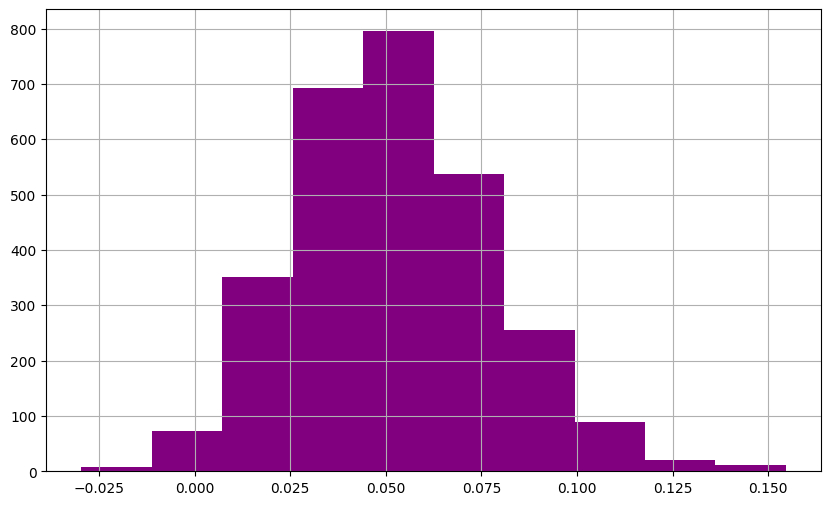

In [39]:
plt.figure(figsize = (10,6))
news_data['Polarity'].hist(color = 'purple')

<Axes: >

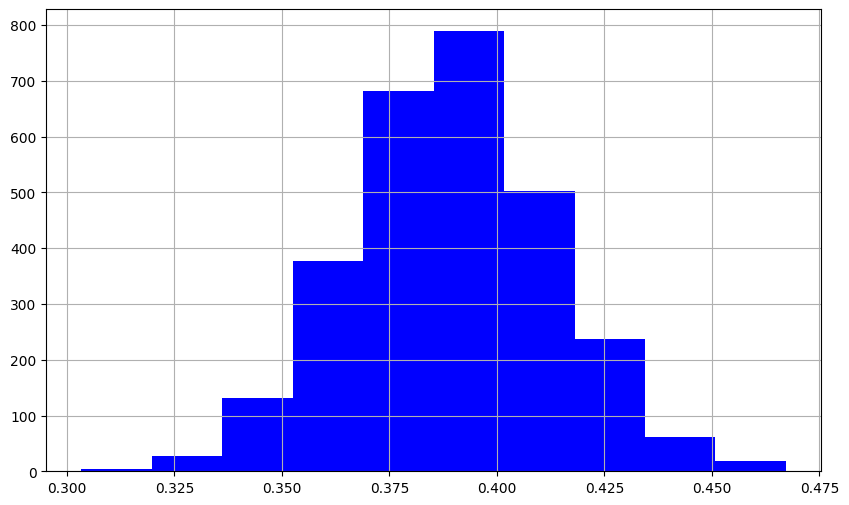

In [40]:
plt.figure(figsize = (10,6))
news_data['Subjectivity'].hist(color = 'blue')

In [41]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

news_data['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_data['news']]
news_data['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_data['news']]
news_data['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_data['news']]
news_data['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_data['news']]
news_data

,date,news,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2014-07-01,recipe: delicious tiramisu god helps romance f...,0.395331,0.068838,-0.9998,0.165,0.729,0.106
1,2014-07-02,top 10 mistakes kareena kapoor made secret hap...,0.398773,0.071994,-0.9997,0.153,0.731,0.116
2,2014-07-03,carb diet healthy weight loss diet? popping di...,0.405117,0.061587,-0.9999,0.186,0.706,0.108
3,2014-07-04,bollywood actors live-in relationships strawbe...,0.437297,0.063480,-0.9996,0.147,0.741,0.112
4,2014-07-05,good take break marriage recipe: chocolate pea...,0.396619,0.070666,-0.9998,0.163,0.727,0.110
...,...,...,...,...,...,...,...,...
2826,2022-03-27,playing dead man body god meant sitting refrig...,0.357598,0.024528,-0.9998,0.157,0.758,0.085
2827,2022-03-28,fashion becomes democratic; demand stylists so...,0.376143,0.051627,-0.9997,0.148,0.752,0.099
2828,2022-03-29,bobby deol: like dad; hope working age yashas ...,0.395730,0.086646,-0.9997,0.139,0.774,0.087
2829,2022-03-30,give trends: dossmode time gave boyfriend incr...,0.338994,0.024901,-0.9998,0.154,0.761,0.084


### Hybrid Analysis

In [68]:
df_merge = pd.merge(df, news_data, how='inner',left_on='Date', right_on='date')
df_merge.head()

,Date,Open,High,Low,Close,Adj Close,Volume,date,news,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2014-07-01,25469.939453,25571.900391,25466.769531,25516.349609,25516.349609,10600,2014-07-01,recipe: delicious tiramisu god helps romance f...,0.395331,0.068838,-0.9998,0.165,0.729,0.106
1,2014-07-02,25660.570312,25864.529297,25660.160156,25841.210938,25841.210938,12300,2014-07-02,top 10 mistakes kareena kapoor made secret hap...,0.398773,0.071994,-0.9997,0.153,0.731,0.116
2,2014-07-03,25875.750000,25999.080078,25793.699219,25823.750000,25823.750000,3700,2014-07-03,carb diet healthy weight loss diet? popping di...,0.405117,0.061587,-0.9999,0.186,0.706,0.108
3,2014-07-04,25844.800781,25981.509766,25659.330078,25962.060547,25962.060547,9500,2014-07-04,bollywood actors live-in relationships strawbe...,0.437297,0.063480,-0.9996,0.147,0.741,0.112
4,2014-07-07,26039.669922,26123.550781,25992.730469,26100.080078,26100.080078,8900,2014-07-07,dad nagging city's street eats get better cind...,0.389375,0.086377,-0.9983,0.141,0.733,0.126


In [186]:
data = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,25516.349609,0.395331,0.068838,-0.9998,0.165,0.729,0.106
1,25841.210938,0.398773,0.071994,-0.9997,0.153,0.731,0.116
2,25823.750000,0.405117,0.061587,-0.9999,0.186,0.706,0.108
3,25962.060547,0.437297,0.063480,-0.9996,0.147,0.741,0.112
4,26100.080078,0.389375,0.086377,-0.9983,0.141,0.733,0.126
...,...,...,...,...,...,...,...
1895,57362.199219,0.360500,-0.026224,-0.9999,0.167,0.758,0.075
1896,57593.488281,0.376143,0.051627,-0.9997,0.148,0.752,0.099
1897,57943.648438,0.395730,0.086646,-0.9997,0.139,0.774,0.087
1898,58683.988281,0.338994,0.024901,-0.9998,0.154,0.761,0.084


In [166]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
new_df = scaler.fit_transform(data)
new_df = pd.DataFrame(new_df, columns=data.columns)
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,-1.065293,0.331316,0.776953,-0.151409,0.797646,-0.950850,0.313657
1,-1.031979,0.478829,0.902546,-0.151052,-0.022593,-0.835201,0.971583
2,-1.033770,0.750689,0.488358,-0.151767,2.233062,-2.280816,0.445242
3,-1.019587,2.129812,0.563710,-0.150694,-0.432712,-0.256954,0.708412
4,-1.005433,0.076076,1.474954,-0.146044,-0.842831,-0.719551,1.629508


In [167]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [168]:
from sklearn.model_selection import train_test_split

In [169]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(1520, 6)

In [182]:
from sklearn.linear_model import LinearRegression
# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(x_train, y_train)

LinearRegression()

In [183]:
rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.789608767564472


In [178]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(x_train, y_train)

rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.7694157715513876


In [90]:
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:", best_params)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [177]:
model = RandomForestRegressor(n_estimators=300, random_state=0, max_depth=5, min_samples_leaf=4, min_samples_split=10)
model.fit(x_train, y_train)

rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.7393668503871906


In [176]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(n_estimators=100, random_state=0)
model.fit(x_train, y_train)

rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.8099308878569709


In [175]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, random_state=0)
model.fit(x_train, y_train)

rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.7422258189446173


In [174]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, random_state=0)
model.fit(x_train, y_train)

rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.8228059821156193


In [94]:
# prompt: do a detail grid search for above xgbregressor, by using the colab t4 gpu

import numpy as np
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 5, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300]
}

# Create the grid search object
grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=0), param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:", best_params)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.5}


In [173]:
# Create a new XGBRegressor with the best hyperparameters
model = xgb.XGBRegressor(**best_params)

# Train the model with the best hyperparameters
model.fit(x_train, y_train)

rmse = mean_squared_error(y_test, model.predict(x_test),squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.7387703460238888


## Conclusion
The XGBoost model has achieved its lowest RMSE after extensive tuning efforts, indicating optimal performance with current methodologies. Further marginal improvements in RMSE may be done.
Focus now shifts to ensuring model stability and interpretability, while remaining open to future enhancements as new data or techniques emerge.